In [1]:
%pip install mplcyberpunk
%pip install ruts
%pip install shap
%pip install pymystem3
%pip install slovnet
%pip install evaluate
%pip install rouge_score
%pip install crosslingual-coreference
%pip install spacy
%pip install https://github.com/explosion/spacy-models/releases/download/ru_core_news_sm-3.7.0/ru_core_news_sm-3.7.0.tar.gz
%pip install seaborn
%pip install catboost==1.2
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd 
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from pymystem3 import Mystem
from tqdm import tqdm
import csv

from ruts import BasicStats, ReadabilityStats, DiversityStats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from dataclasses import dataclass, field
import collections
from typing import List

import shap
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
russian_stopwords = set(stopwords.words('russian'))

from navec import Navec
from slovnet import NER, Morph
from razdel import sentenize, tokenize

from evaluate import load

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/irinanovikova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/irinanovikova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Preprocessing**

In [ ]:
path_to_equal = ""
path_to_different = ""

In [7]:
equal_themes_df = pd.read_csv(path_to_equal, encoding='utf-8')
different_themes_df = pd.read_csv(path_to_different, encoding='utf-8')

In [8]:
equal_themes_df.info(), different_themes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1822 entries, 0 to 1821
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   topic               1822 non-null   object
 1   human-written text  1822 non-null   object
 2   prompt              1822 non-null   object
 3   neural text         1822 non-null   object
dtypes: object(4)
memory usage: 57.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1822 entries, 0 to 1821
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   topic               1809 non-null   object
 1   human-written text  1809 non-null   object
 2   prompt              1822 non-null   object
 3   neural text         1822 non-null   object
dtypes: object(4)
memory usage: 57.1+ KB


(None, None)

In [9]:
different_themes_df.dropna(axis=0, inplace=True)
different_themes_df.reset_index(inplace=True, drop=True)

In [10]:
equal_themes_df.head()

,topic,human-written text,prompt,neural text
0,Серебренникова увезли на допрос в ГСУ,Режиссер Кирилл Серебренников из своей квартир...,Напиши новостной человекоподобный текст по дан...,Вчера известного режиссера Кирилла Серебренник...
1,«Дом с башенкой» на Пяти углах освободили от в...,"С фасада Дома купца Иоффа, более известного ка...",Напиши новостной человекоподобный текст по дан...,Вчера вечером в историческом центре города на ...
2,«Дом надежды на Горе» отметит день рождения бо...,Межрегиональный Фонд «Центр реабилитации «Дом ...,Напиши новостной человекоподобный текст по дан...,«Дом надежды на Горе» отметит свой день рожден...
3,Суд проверит законность ареста имущества скуль...,Мосгорсуд проверит законность ареста имущества...,Напиши новостной человекоподобный текст по дан...,Верховный суд объявил о намерении провести рас...
4,"СМИ: Академик Фортов госпитализирован, вместо ...",Действующий президент РАН Владимир Фортов нахо...,Напиши новостной человекоподобный текст по дан...,"По последним сообщениям СМИ, выдающийся россий..."


In [11]:
different_themes_df.head()

,topic,human-written text,prompt,neural text
0,Кремль ответил на сообщения об отдыхе губернат...,У Кремля нет позиции по поводу отдыха чиновник...,Напиши новостной человекоподобный текст по дан...,Вчера известного режиссера Кирилла Серебренник...
1,Пятеро рабочих в Москве погибли от испарений в...,Пять человек погибли в канализационном коллект...,Напиши новостной человекоподобный текст по дан...,Вчера вечером в историческом центре города на ...
2,"Ай да долг, да под арест",Скандально известный бренд областной недвижимо...,Напиши новостной человекоподобный текст по дан...,«Дом надежды на Горе» отметит свой день рожден...
3,Саакашвили попросил у Украины политического уб...,"Бывший президент Грузии, экс-губернатор Одесск...",Напиши новостной человекоподобный текст по дан...,Верховный суд объявил о намерении провести рас...
4,ЗакС рассмотрит кандидатуру Анны Митяниной на ...,Губернатор Петербурга Георгий Полтавчено внес ...,Напиши новостной человекоподобный текст по дан...,"По последним сообщениям СМИ, выдающийся россий..."


In [12]:
lengths_human_texts = [len(text.split(' ')) for text in equal_themes_df['human-written text']]
lengths_neural_texts = [len(text.split(' ')) for text in equal_themes_df['neural text']]
np.mean(lengths_human_texts), np.mean(lengths_neural_texts)

(224.1410537870472, 235.9165751920966)

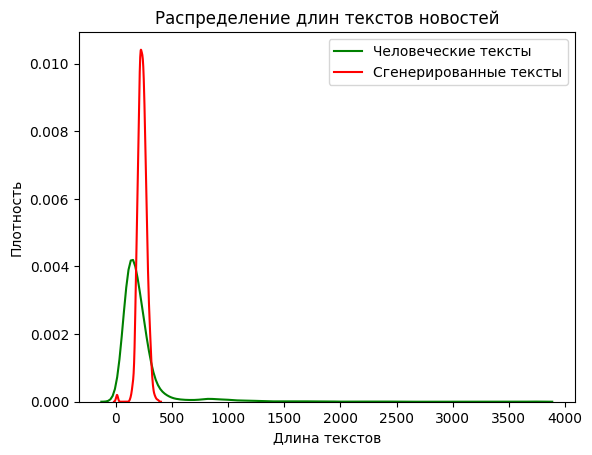

In [13]:
# Добавить clip
sns.kdeplot(lengths_human_texts, color='green', label='Человеческие тексты')
sns.kdeplot(lengths_neural_texts, color='red', label='Сгенерированные тексты')
plt.xlabel('Длина текстов')
plt.ylabel('Плотность')
plt.title('Распределение длин текстов новостей')
plt.legend()
plt.savefig('news_lengths_distribution')
plt.show()

In [14]:
class DatasetPreprocessor:
    def __init__(self, dataframe, source: str, target: str):
        self.df = dataframe
        self.source_column = source
        self.target_column = target

    def analyse_dataset(self):
        print(self.df.head())
        print(self.df.info())
        print(f'Shape: {self.df.shape}')
        print(f'Number of NaN: {self.df.isnull().sum()}')
        print(f'Number of duplicates: {self.df.duplicated().sum()}')

    def basic_preprocess(self):
        self.df.dropna(axis=0, inplace=True)
        self.df.drop_duplicates(f'{self.source_column}', inplace=True)
        self.df.drop_duplicates(f'{self.target_column}', inplace=True)
        self.df.reset_index(inplace=True, drop=True)
        return self.df

    def remove_garbage(self, text: str):
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\n', '', text)
        return text

In [15]:
preprocessor_equal = DatasetPreprocessor(equal_themes_df, 'human-written text', 'neural text')
processed_equal_df = preprocessor_equal.basic_preprocess()

cleaned_human_equal = [preprocessor_equal.remove_garbage(text) for text in processed_equal_df['human-written text']]
human_equal = {'text': cleaned_human_equal, 'class': 0}
human_equal_df = pd.DataFrame(human_equal)

cleaned_neural_equal = [preprocessor_equal.remove_garbage(text) for text in processed_equal_df['neural text']]
neural_equal = {'text': cleaned_neural_equal, 'class': 1}
neural_equal_df = pd.DataFrame(neural_equal)

equal_df = pd.concat([human_equal_df, neural_equal_df])
equal_df.head()

,text,class
0,Режиссер Кирилл Серебренников из своей квартир...,0
1,"С фасада Дома купца Иоффа, более известного ка...",0
2,Межрегиональный Фонд «Центр реабилитации «Дом ...,0
3,Мосгорсуд проверит законность ареста имущества...,0
4,Действующий президент РАН Владимир Фортов нахо...,0


In [16]:
preprocessor_different = DatasetPreprocessor(different_themes_df, 'human-written text', 'neural text')
processed_different_df = preprocessor_different.basic_preprocess()

cleaned_human_equal = [preprocessor_different.remove_garbage(text) for text in processed_different_df['human-written text']]
human_different = {'text': cleaned_human_equal, 'class': 0}
human_different_df = pd.DataFrame(human_different)

cleaned_neural_different = [preprocessor_different.remove_garbage(text) for text in processed_different_df['neural text']]
neural_different = {'text': cleaned_neural_different, 'class': 1}
neural_different_df = pd.DataFrame(neural_different)

different_df = pd.concat([human_different_df, neural_different_df])
different_df.head()

,text,class
0,У Кремля нет позиции по поводу отдыха чиновник...,0
1,Пять человек погибли в канализационном коллект...,0
2,Скандально известный бренд областной недвижимо...,0
3,"Бывший президент Грузии, экс-губернатор Одесск...",0
4,Губернатор Петербурга Георгий Полтавчено внес ...,0


In [17]:
equal_df.info(), different_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 0 to 1814
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3630 non-null   object
 1   class   3630 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 85.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3604 entries, 0 to 1801
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3604 non-null   object
 1   class   3604 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 84.5+ KB


(None, None)

In [18]:
long_mask_different = different_df['text'].apply(lambda x: len(x.split(' ')) >= 1000)
different_df = different_df[~long_mask_different]

small_mask_different = different_df['text'].apply(lambda x: len(x.split(' ')) <= 100)
different_df = different_df[~small_mask_different]

different_df.reset_index(inplace=True, drop=True)

long_mask_equal = equal_df['text'].apply(lambda x: len(x.split(' ')) >= 2000)
equal_df = equal_df[~long_mask_equal]

small_mask_equal = equal_df['text'].apply(lambda x: len(x.split(' ')) <= 100)
equal_df = equal_df[~small_mask_equal]

equal_df.reset_index(inplace=True, drop=True)

In [19]:
equal_df.info(), different_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3247 entries, 0 to 3246
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3247 non-null   object
 1   class   3247 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 50.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3167 entries, 0 to 3166
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3167 non-null   object
 1   class   3167 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 49.6+ KB


(None, None)

## **Basic statistics**

In [20]:
@dataclass
class TextStatsCollection:
    n_letters: List[int] = field(default_factory=list)
    n_syllables: List[int] = field(default_factory=list)
    n_words: List[int] = field(default_factory=list)
    n_words_per_sentence: List[float] = field(default_factory=list)
    n_simple_words: List[int] = field(default_factory=list)
    n_simple_words_per_sentence: List[float] = field(default_factory=list)
    n_monosyllable_words: List[int] = field(default_factory=list)
    n_monosyllable_words_per_sentence: List[float] = field(default_factory=list)
    n_polysyllable_words: List[int] = field(default_factory=list)
    n_polysyllable_words_per_sentence: List[float] = field(default_factory=list)
    n_long_words: List[int] = field(default_factory=list)
    n_long_words_per_sentence: List[float] = field(default_factory=list)
    n_complex_words: List[int] = field(default_factory=list)
    n_complex_words_per_sentence: List[float] = field(default_factory=list)
    n_unique_words_per_sentence: List[float] = field(default_factory=list)
    n_sents: List[int] = field(default_factory=list)
    n_punctuations: List[int] = field(default_factory=list)
    n_punctuations_per_sentence: List[float] = field(default_factory=list)

In [21]:
def get_statistics(df):
    stats = TextStatsCollection()
    
    for text in df.text: 
        bs = BasicStats(text)
        stats.n_letters.append(bs.n_letters / bs.n_words)
        stats.n_syllables.append(bs.n_syllables / bs.n_words)
        stats.n_words.append(bs.n_words)
        stats.n_words_per_sentence.append(bs.n_words / bs.n_sents)
        stats.n_simple_words.append(bs.n_simple_words / bs.n_words)
        stats.n_simple_words_per_sentence.append(bs.n_simple_words / bs.n_sents)
        stats.n_monosyllable_words.append(bs.n_monosyllable_words / bs.n_words)
        stats.n_monosyllable_words_per_sentence.append(bs.n_monosyllable_words / bs.n_sents)
        stats.n_polysyllable_words.append(bs.n_polysyllable_words / bs.n_words)
        stats.n_polysyllable_words_per_sentence.append(bs.n_polysyllable_words / bs.n_sents)
        stats.n_long_words.append(bs.n_long_words / bs.n_words)
        stats.n_long_words_per_sentence.append(bs.n_long_words / bs.n_sents)
        stats.n_complex_words.append(bs.n_complex_words / bs.n_words)
        stats.n_complex_words_per_sentence.append(bs.n_complex_words / bs.n_sents)
        stats.n_unique_words_per_sentence.append(bs.n_unique_words / bs.n_sents)
        stats.n_sents.append(bs.n_sents / bs.n_words)
        stats.n_punctuations.append(bs.n_punctuations / bs.n_words)
        stats.n_punctuations_per_sentence.append(bs.n_punctuations / bs.n_sents)
    
    return stats

In [22]:
statistics_equal = get_statistics(equal_df)
statistics_different = get_statistics(different_df)

In [23]:
# Basic statistics for equal thematics
equal_df['n_letters'] = statistics_equal.n_letters
equal_df['n_syllables'] = statistics_equal.n_syllables
equal_df['n_words'] = statistics_equal.n_words
equal_df['n_words_per_sentence'] = statistics_equal.n_words_per_sentence
equal_df['n_simple_words'] = statistics_equal.n_simple_words
equal_df['n_simple_words_per_sentence'] = statistics_equal.n_simple_words_per_sentence
equal_df['n_monosyllable_words'] = statistics_equal.n_monosyllable_words
equal_df['n_monosyllable_words_per_sentence'] = statistics_equal.n_monosyllable_words_per_sentence
equal_df['n_polysyllable_words'] = statistics_equal.n_polysyllable_words
equal_df['n_polysyllable_words_per_sentence'] = statistics_equal.n_polysyllable_words_per_sentence
equal_df['n_long_words'] = statistics_equal.n_long_words
equal_df['n_long_words_per_sentence'] = statistics_equal.n_long_words_per_sentence
equal_df['n_complex_words'] = statistics_equal.n_complex_words
equal_df['n_complex_words_per_sentence'] = statistics_equal.n_complex_words_per_sentence
equal_df['n_unique_words_per_sentence'] = statistics_equal.n_unique_words_per_sentence
equal_df['n_sents'] = statistics_equal.n_sents
equal_df['n_punctuations'] = statistics_equal.n_punctuations
equal_df['n_punctuations_per_sentence'] = statistics_equal.n_punctuations_per_sentence

In [24]:
# Basic statistics for different thematics
different_df['n_letters'] = statistics_different.n_letters
different_df['n_syllables'] = statistics_different.n_syllables
different_df['n_words'] = statistics_different.n_words
different_df['n_words_per_sentence'] = statistics_different.n_words_per_sentence
different_df['n_simple_words'] = statistics_different.n_simple_words
different_df['n_simple_words_per_sentence'] = statistics_different.n_simple_words_per_sentence
different_df['n_monosyllable_words'] = statistics_different.n_monosyllable_words
different_df['n_monosyllable_words_per_sentence'] = statistics_different.n_monosyllable_words_per_sentence
different_df['n_polysyllable_words'] = statistics_different.n_polysyllable_words
different_df['n_polysyllable_words_per_sentence'] = statistics_different.n_polysyllable_words_per_sentence
different_df['n_long_words'] = statistics_different.n_long_words
different_df['n_long_words_per_sentence'] = statistics_different.n_long_words_per_sentence
different_df['n_complex_words'] = statistics_different.n_complex_words
different_df['n_complex_words_per_sentence'] = statistics_different.n_complex_words_per_sentence
different_df['n_unique_words_per_sentence'] = statistics_different.n_unique_words_per_sentence
different_df['n_sents'] = statistics_different.n_sents
different_df['n_punctuations'] = statistics_different.n_punctuations
different_df['n_punctuations_per_sentence'] = statistics_different.n_punctuations_per_sentence

## **Readability scores**

In [27]:
def get_readability_scores(df):
    flesch_kincaid_grade = []
    flesch_reading_easy = []

    for index in range(len(df.text)):
        rs = ReadabilityStats(df.text.iloc[index])
        flesch_kincaid_grade.append(rs.flesch_kincaid_grade)
        flesch_reading_easy.append(rs.flesch_reading_easy)
    return flesch_kincaid_grade, flesch_reading_easy

In [28]:
readability_scores_equal = get_readability_scores(equal_df)
readability_scores_different = get_readability_scores(different_df)

In [29]:
# Readability scores fot equal thematics
equal_df['flesch_kincaid_grade'] = readability_scores_equal[0]
equal_df['flesch_reading_easy'] = readability_scores_equal[1]

In [30]:
# Readability scores fot different thematics
different_df['flesch_kincaid_grade'] = readability_scores_different[0]
different_df['flesch_reading_easy'] = readability_scores_different[1]

## **Lexical diversity scores**

In [33]:
def get_lexical_diversity_scores(df):
    mtld = []
    hdd = []

    for index in range(len(df.text)):
        ds = DiversityStats(df.text.iloc[index])
        mtld.append(ds.mtld)
        hdd.append(ds.hdd)
    return mtld, hdd

In [34]:
lexical_diversity_equal = get_lexical_diversity_scores(equal_df)
lexical_diversity_different = get_lexical_diversity_scores(different_df)

In [35]:
# Lexical diversity scores fot equal thematics
equal_df['mtld'] = lexical_diversity_equal[0]
equal_df['hdd'] = lexical_diversity_equal[1]

In [36]:
# Lexical diversity scores fot different thematics
different_df['mtld'] = lexical_diversity_different[0]
different_df['hdd'] = lexical_diversity_different[1]

## **Repetitiveness**

In [38]:
most_frequent_words_df = pd.read_csv('most_frequent_russian_words.csv', encoding='utf-8')
most_frequent_words = most_frequent_words_df['Лемма']

In [39]:
punctuation_marks = ['.', ',', '?', '!', ';', ':', "'", '"', '(', ')', '[', ']', '{', '}', '-', '–', '—', 
                     '/', '\\', '*', '&', '%', '$', '#', '@', '+', '=', '<', '>', '|', '~', '^', '`']

def lemmatize(df):
    lemmatized_corpora = []
    mystem = Mystem()
    for text in df.text:
        lemmas = mystem.lemmatize(text)
        lemmatized_text = ''.join(lemmas)
        lemmatized_corpora.append(lemmatized_text)
    df['lemmatized_text'] = lemmatized_corpora
    return df


def get_unique_words(df):
    number_unique_words = {}
    for index in range(len(df.lemmatized_text)):
        text = df.lemmatized_text.iloc[index]
        freq_per_text = {}
        tokens = tokenize(text)
        for token in tokens:
            if token.text in punctuation_marks:
                continue
            elif token.text not in freq_per_text:
                freq_per_text[token.text] = 0
            freq_per_text[token.text] += 1
        number_unique_words[index] = len(freq_per_text.keys()) / df.n_words.iloc[index]
    return number_unique_words

def get_top_list_words(df):
    counter_dict = {index: 0 for index in range(len(df.text))}
    for index in tqdm(range(len(df.lemmatized_text))):
        text = df.lemmatized_text.iloc[index]
        tokens = text.split(' ')
        for word in most_frequent_words:
            if word in tokens:
                counter_dict[index] += 1 / df.n_words.iloc[index]
    return counter_dict

def get_number_of_stop_words(df): 
    counter_dict = {index: 0 for index in range(len(df.text))}
    for index in tqdm(range(len(df.lemmatized_text))):
        text = df.lemmatized_text.iloc[index]
        tokens = tokenize(text)
        for token in tokens:
            if token.text in russian_stopwords:
                counter_dict[index] += 1 / df.n_words.iloc[index]
    return counter_dict

def get_number_of_unique_stop_words(df): 
    counter_dict = {index: 0 for index in range(len(df.text))}
    for index in tqdm(range(len(df.lemmatized_text))):
        text = df.lemmatized_text.iloc[index]
        tokens = tokenize(text)
        unique_stop_words = {}
        for token in tokens:
            if token.text in russian_stopwords: 
                if token.text not in unique_stop_words:
                    unique_stop_words[token.text] = 0
                unique_stop_words[token.text] += 1
        counter_dict[index] = len(unique_stop_words.keys()) / df.n_words.iloc[index]
    return counter_dict

In [40]:
equal_df = lemmatize(equal_df)
different_df = lemmatize(different_df)

In [42]:
equal_df['number_of_unique_words'] = get_unique_words(equal_df)
equal_df['number_of_top_list_words'] = get_top_list_words(equal_df)
equal_df['number_of_stop_words'] = get_number_of_stop_words(equal_df)
equal_df['number_of_unique_stop_words'] = get_number_of_unique_stop_words(equal_df)

100%|██████████| 3247/3247 [00:01<00:00, 2103.36it/s]


In [43]:
different_df['number_of_unique_words'] = get_unique_words(different_df)
different_df['number_of_top_list_words'] = get_top_list_words(different_df)
different_df['number_of_stop_words'] = get_number_of_stop_words(different_df)
different_df['number_of_unique_stop_words'] = get_number_of_unique_stop_words(different_df)

100%|██████████| 3167/3167 [00:01<00:00, 2206.10it/s]


## **NER**

In [46]:
class NERMarkuper:
    def __init__(self, df):
        self.df = df
        navec = Navec.load('vocab/navec_news_v1_1B_250K_300d_100q.tar')
        self.ner = NER.load('vocab/slovnet_ner_news_v1.tar')
        self.ner.navec(navec)

    def get_ners(self):
        unique_ner = {}
        number_of_ner_per_text = {}
        for index in tqdm(range(len(self.df.text))):
            text = self.df.text[index]
            unique_ner_per_text = {}
            unique_ner_type_per_text = {}
            markup = self.ner(text)
            for span in markup.spans:
                if text[span.start:span.stop] not in unique_ner_per_text:
                    unique_ner_per_text[text[span.start:span.stop]] = 0
                unique_ner_per_text[text[span.start:span.stop]] += 1

            for span in markup.spans:
                if span.type not in unique_ner_type_per_text:
                    unique_ner_type_per_text[span.type] = 0
                unique_ner_type_per_text[span.type] += 1

            unique_ner[index] = len(unique_ner_per_text.keys()) / self.df.n_words.iloc[index]
            number_of_ner_per_text[index] = sum(list(unique_ner_type_per_text.values())) / self.df.n_words.iloc[index]

        return unique_ner, number_of_ner_per_text

    def get_mean_ner_per_sentence(self):
        mean_ner_per_sentence = []
        for index in tqdm(range(len(self.df.text))):
            text = self.df.text[index]
            number_of_ner = []
            sentenized_text = list(sentenize(text))
            for sentence in sentenized_text:
                sentence = sentence.text
                markup = self.ner(sentence)
                number_of_ner.append(len(markup.spans))
            mean_ner_per_sentence.append(np.mean(number_of_ner))
        return mean_ner_per_sentence

In [47]:
ner_markuper_equal = NERMarkuper(equal_df)
ners_equal = ner_markuper_equal.get_ners()

equal_df['unique_ner'] = ners_equal[0]
equal_df['number_of_ner_per_text'] = ners_equal[1]
equal_df['mean_ner_per_sentence'] = ner_markuper_equal.get_mean_ner_per_sentence()

100%|██████████| 3247/3247 [00:44<00:00, 73.16it/s]


In [48]:
ner_markuper_different = NERMarkuper(different_df)
ners_different = ner_markuper_different.get_ners()

different_df['unique_ner'] = ners_different[0]
different_df['number_of_ner_per_text'] = ners_different[1]
different_df['mean_ner_per_sentence'] = ner_markuper_different.get_mean_ner_per_sentence()

100%|██████████| 3167/3167 [00:41<00:00, 76.60it/s]


## **POS**

In [49]:
class POSMarkuper:
    def __init__(self, df):
        self.df = df
        navec = Navec.load('vocab/navec_news_v1_1B_250K_300d_100q.tar')
        self.morph = Morph.load('vocab/slovnet_morph_news_v1.tar', batch_size=4)
        self.morph.navec(navec)
        self.chunks = self.preprocess()

    def preprocess(self):
        all_chunks = []
        for text in self.df.text:
            text_chunks = []
            for sent in sentenize(text):
                tokens = [_.text for _ in tokenize(sent.text)]
                text_chunks.append(tokens)
            all_chunks.append(text_chunks)
        return all_chunks

    def get_morph_stats(self): 
        number_nouns = {i: 0 for i in range(len(self.chunks))}
        number_verbs = {i: 0 for i in range(len(self.chunks))}
        number_adj = {i: 0 for i in range(len(self.chunks))}
        number_pronouns = {i: 0 for i in range(len(self.chunks))}
        number_nums = {i: 0 for i in range(len(self.chunks))}
        for i in range(len(self.chunks)): 
            chunk = self.chunks[i]
            for markup in self.morph.map(chunk): 
                for token in markup.tokens:
                    if token.pos == 'NOUN':
                        number_nouns[i] = number_nouns.get(i, 0) + 1 / self.df.n_words.iloc[i]
                    elif token.pos == 'VERB':
                        number_verbs[i] = number_verbs.get(i, 0) + 1 / self.df.n_words.iloc[i]
                    elif token.pos == 'ADJ':
                        number_adj[i] = number_adj.get(i, 0) + 1 / self.df.n_words.iloc[i]
                    elif token.pos == 'PROPN':
                        number_pronouns[i] = number_pronouns.get(i, 0) + 1 / self.df.n_words.iloc[i]
                    elif token.pos == 'NUM':
                        number_nums[i] = number_nums.get(i, 0) + 1 / self.df.n_words.iloc[i]
        return number_nouns, number_verbs, number_adj, number_pronouns, number_nums

    def get_functional_words(self):
        functional_words_count = []
        for i in range(len(self.chunks)):
            chunk = self.chunks[i]
            functional_words_per_text = 0
            for markup in self.morph.map(chunk): 
                for token in markup.tokens:
                    if token.pos == 'ADP' or token.pos == 'CCONJ' or token.pos == 'PART':
                        functional_words_per_text += 1 / self.df.n_words.iloc[i]
            functional_words_count.append(functional_words_per_text)
        return functional_words_count

In [50]:
morph_markuper_equal = POSMarkuper(equal_df)
morph_markup_equal = morph_markuper_equal.get_morph_stats()

equal_df['number_nouns'] = morph_markup_equal[0]
equal_df['number_verbs'] = morph_markup_equal[1]
equal_df['number_adj'] = morph_markup_equal[2]
equal_df['number_pronouns'] = morph_markup_equal[3]
equal_df['number_nums'] = morph_markup_equal[4]
equal_df['number_of_func_words'] = morph_markuper_equal.get_functional_words()

In [51]:
morph_markuper_different = POSMarkuper(different_df)
morph_markup_different = morph_markuper_different.get_morph_stats()

different_df['number_nouns'] = morph_markup_different[0]
different_df['number_verbs'] = morph_markup_different[1]
different_df['number_adj'] = morph_markup_different[2]
different_df['number_pronouns'] = morph_markup_different[3]
different_df['number_nums'] = morph_markup_different[4]
different_df['number_of_func_words'] = morph_markuper_different.get_functional_words()

## **ROUGE-1, ROUGE-2, ROUGE-L**

In [54]:
rouge = load('rouge')

def get_metric(df):
    mystem = Mystem()
    rouge_metrics = []
    rouge_1_metrics = []
    rouge_2_metrics = []
    rouge_l_metrics = []
    for index in tqdm(range(len(df.text))):
        text = df.text.iloc[index]
        sentences = list(sentenize(text))
        predictions = []
        references = []
        for i in range(len(sentences) - 1):
            predictions.append(''.join(mystem.lemmatize(sentences[i].text)[:-2]))
            references.append(''.join(mystem.lemmatize(sentences[i + 1].text)[:-2]))
        rouge_metrics = get_rouge(predictions, references)
        rouge_1_metrics.append(rouge_metrics['rouge1'])
        rouge_2_metrics.append(rouge_metrics['rouge2'])
        rouge_l_metrics.append(rouge_metrics['rougeL'])

    return rouge_1_metrics, rouge_2_metrics, rouge_l_metrics

def get_rouge(predictions, references):
    result = rouge.compute(predictions=predictions, references=references, use_stemmer=False, tokenizer=lambda x: [
                                                token.text.lower() for token in tokenize(x)])
    return result

In [55]:
metrics_equal = get_metric(equal_df)
metrics_different = get_metric(different_df)

100%|██████████| 3167/3167 [02:44<00:00, 19.30it/s]


In [56]:
equal_df['rouge_1'] = metrics_equal[0]
equal_df['rouge_2'] = metrics_equal[1]
equal_df['rouge_l'] = metrics_equal[2]

In [57]:
different_df['rouge_1'] = metrics_different[0]
different_df['rouge_2'] = metrics_different[1]
different_df['rouge_l'] = metrics_different[2]

## **Similarity of syntactic structure** 

In [59]:
model = spacy.load("ru_core_news_sm")

In [60]:
def make_syntax_markup(df): 
    df_with_markup = {}
    for index in tqdm(range(len(df.text))):
        text_with_markup = []
        text = df.text.iloc[index]
        sentences = list(sentenize(text))
        for sentence in sentences: 
            sentence_with_markup = []
            sentence = model(sentence.text)
            for token in sentence:
                if token.dep_ == 'punct':
                    continue
                else: 
                    sentence_with_markup.append(f'{token.pos_}_{token.dep_}')
            text_with_markup.append(' '.join(sentence_with_markup))
        df_with_markup[index] = text_with_markup
    return df_with_markup

In [62]:
class Score(collections.namedtuple("Score", ["precision", "recall", "fmeasure"])):

  def fmeasure(precision, recall):
      if precision + recall > 0:
          return 2 * precision * recall / (precision + recall)
      else:
          return 0.0


class CustomRougeLScorer:
  def __init__(self, min_subseq_len=2):
    self.min_subseq_len = min_subseq_len

  def calculate(self, predictions, targets, tokenization):
    if len(predictions) != len(targets):
      raise ValueError("The lengths of predictions and targets don't match.")

    tokenized_predictions = [tokenization(prediction) for prediction in predictions]
    tokenized_targets = [tokenization(target) for target in targets]

    scores = [self.score(tokenized_predictions[i], tokenized_targets[i]) for i in range(len(tokenized_predictions))]
    fmeasure = np.mean([score["rougeL"][2] for score in scores])

    return fmeasure


  def score(self, target_tokens, prediction_tokens):
    result = {}

    lcs_length = self._contiguous_lcs_length(target_tokens, prediction_tokens)
    if lcs_length < self.min_subseq_len:
      result["rougeL"] = Score(precision=0, recall=0, fmeasure=0)
      return result

    precision = lcs_length / len(prediction_tokens)
    recall = lcs_length / len(target_tokens)
    fmeasure_result = fmeasure(precision, recall)

    result["rougeL"] = Score(precision=precision, recall=recall, fmeasure=fmeasure_result)

    return result


  def _contiguous_lcs_length(self, tokens1, tokens2):
    dp = [[0] * (len(tokens2) + 1) for _ in range(len(tokens1) + 1)]
    longest = 0
    for i in range(1, len(tokens1) + 1):
      for j in range(1, len(tokens2) + 1):
        if tokens1[i - 1] == tokens2[j - 1]:
          dp[i][j] = dp[i - 1][j - 1] + 1
          if dp[i][j] >= self.min_subseq_len:
            longest = max(longest, dp[i][j])
        else:
          dp[i][j] = 0

    return longest

In [63]:
def get_parallel_structures(df): 
    rouge_scorer = CustomRougeLScorer()
    rouge = []
    for index in tqdm(range(len(df.syntax_markup))):
        predictions = []
        references = []
        text = df.syntax_markup.iloc[index]
        for i in range(len(text) - 1): 
            predictions.append(text[i])
            references.append(text[i + 1])
        rouge.append(rouge_scorer.calculate(predictions, references, lambda x: x.split(' ')))
    return rouge

In [64]:
def make_morph_markup(df): 
    df_with_markup = {}
    for index in tqdm(range(len(df.text))):
        text_with_markup = []
        text = df.text.iloc[index]
        sentences = list(sentenize(text))
        for sentence in sentences: 
            sentence_with_markup = []
            sentence = model(sentence.text)
            for token in sentence:
                if token.pos_ == 'PUNCT':
                    continue 
                else: 
                    sentence_with_markup.append(token.pos_)
            text_with_markup.append(' '.join(sentence_with_markup))
        df_with_markup[index] = text_with_markup
    return df_with_markup

In [65]:
def get_pos_repetitiveness(df): 
    rouge_1 = []
    rouge_2 = []
    rouge_l = []
    for index in tqdm(range(len(df.morph_markup))):
        predictions = []
        references = []
        text = df.morph_markup.iloc[index]
        for i in range(len(text) - 1): 
            predictions.append(text[i])
            references.append(text[i + 1])
        rouge_metrics = get_rouge(predictions, references)
        rouge_1.append(rouge_metrics['rouge1'])
        rouge_2.append(rouge_metrics['rouge2'])
        rouge_l.append(rouge_metrics['rougeL'])
    return rouge_1, rouge_2, rouge_l

In [66]:
def get_rouge_l(predictions, references):
    results = rouge.compute(predictions=predictions, references=references, use_stemmer=False, tokenizer=lambda x: [
                                                token.lower() for token in x.split(' ')])
    return np.mean(results["rougeL"])

In [67]:
equal_df['syntax_markup'] = make_syntax_markup(equal_df).values()
equal_df['parallel_structures_level'] = get_parallel_structures(equal_df)
equal_df['morph_markup'] = make_morph_markup(equal_df).values()
morph_rouge_result = get_pos_repetitiveness(equal_df)

100%|██████████| 3247/3247 [04:10<00:00, 12.97it/s]


In [71]:
equal_df['morph_rouge_1'] = morph_rouge_result[0]
equal_df['morph_rouge_2'] = morph_rouge_result[1]
equal_df['morph_rouge_l'] = morph_rouge_result[2]

In [72]:
different_df['syntax_markup'] = make_syntax_markup(different_df).values()
different_df['parallel_structures_level'] = get_parallel_structures(different_df)
different_df['morph_markup'] = make_morph_markup(different_df).values()
morph_rouge_different_result = get_pos_repetitiveness(different_df)

100%|██████████| 3167/3167 [03:55<00:00, 13.45it/s]


In [76]:
different_df['morph_rouge_1'] = morph_rouge_different_result[0]
different_df['morph_rouge_2'] = morph_rouge_different_result[1]
different_df['morph_rouge_l'] = morph_rouge_different_result[2]

## **Coreference**

In [21]:
nlp = spacy.load("ru_core_news_sm")
nlp.add_pipe("xx_coref", config={"chunk_size": 2500, "chunk_overlap": 2, "device": 0})

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
models/crosslingual-coreference/minilm/model.tar.gz: 358490KB [00:14, 25106.54KB/s]                            


Downloading:   0%|          | 0.00/357 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/489 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/225M [00:00<?, ?B/s]

Some weights of the model checkpoint at nreimers/mMiniLMv2-L12-H384-distilled-from-XLMR-Large were not used when initializing XLMRobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at nreimers/mMiniLMv2-L12-H384-distilled-from-XLMR-Large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-st

In [22]:
def get_clusters(df):
    clusters = []
    mean_cluster_length = []
    for i in tqdm(range(len(df.text))):
        text = df.text[i]
        try: 
            doc = nlp(text)
        except:
            print('Error')
            clusters.append('Error')
            mean_cluster_length.append('Error')
            continue
        clusters.append(len(doc._.coref_clusters))
        cluster_lengths = []
        for cluster in doc._.coref_clusters:
            cluster_lengths.append(len(cluster))
        mean_cluster_length.append(np.mean(cluster_lengths))
    return clusters, mean_cluster_length

In [78]:
equal_directory = 'coref_chains/coref_chains_equal_news.csv'
different_directory = 'coref_chains/coref_chains_different_news.csv'

In [79]:
equal_coreference_df = pd.read_csv(equal_directory)
different_coreference_df = pd.read_csv(different_directory)

In [80]:
equal_df['num_coref_clusters'] = equal_coreference_df['num_clusters']
equal_df['mean_cluster_length'] = equal_coreference_df['mean_cluster_length']

In [81]:
different_df['num_coref_clusters'] = different_coreference_df['num_clusters']
different_df['mean_cluster_length'] = different_coreference_df['mean_cluster_length']

In [85]:
new_num_coref_clusters_equal = []
for i in range(len(equal_df.text)): 
    new_num_coref_clusters_equal.append(int(equal_df.num_coref_clusters.iloc[i]) / equal_df.n_words.iloc[i])
equal_df['num_coref_clusters'] = new_num_coref_clusters_equal

In [87]:
new_num_coref_clusters_different = []
for i in range(len(different_df.text)): 
    new_num_coref_clusters_different.append(int(different_df.num_coref_clusters.iloc[i]) / different_df.n_words.iloc[i])
different_df['num_coref_clusters'] = new_num_coref_clusters_different

## **Normalization**

In [90]:
equal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3247 entries, 0 to 3246
Data columns (total 49 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   text                               3247 non-null   object 
 1   class                              3247 non-null   int64  
 2   n_letters                          3247 non-null   float64
 3   n_syllables                        3247 non-null   float64
 4   n_words                            3247 non-null   int64  
 5   n_words_per_sentence               3247 non-null   float64
 6   n_simple_words                     3247 non-null   float64
 7   n_simple_words_per_sentence        3247 non-null   float64
 8   n_monosyllable_words               3247 non-null   float64
 9   n_monosyllable_words_per_sentence  3247 non-null   float64
 10  n_polysyllable_words               3247 non-null   float64
 11  n_polysyllable_words_per_sentence  3247 non-null   float

In [91]:
equal_df.drop(['text', 'lemmatized_text', 'syntax_markup', 'morph_markup', 'n_words'], axis=1, inplace=True)
equal_df.reset_index(drop=True, inplace=True)

different_df.drop(['text', 'lemmatized_text', 'syntax_markup', 'morph_markup', 'n_words'], axis=1, inplace=True)
different_df.reset_index(drop=True, inplace=True)

In [94]:
class_equal = equal_df['class']
class_different = different_df['class']

In [95]:
equal_df.drop(['class'], axis=1, inplace=True)
equal_df.reset_index(drop=True, inplace=True)

different_df.drop(['class'], axis=1, inplace=True)
different_df.reset_index(drop=True, inplace=True)

In [98]:
X_train_equal, X_test_equal, y_train_equal, y_test_equal = train_test_split(equal_df, class_equal, test_size = 0.2, shuffle=True, stratify=class_equal)
X_train_equal, X_val_equal, y_train_equal, y_val_equal = train_test_split(X_train_equal, y_train_equal, test_size = 0.25, shuffle=True, stratify=y_train_equal)

X_train_different, X_test_different, y_train_different, y_test_different = train_test_split(different_df, class_different, test_size = 0.2, shuffle=True, stratify=class_different)
X_train_different, X_val_different, y_train_different, y_val_different = train_test_split(X_train_different, y_train_different, test_size = 0.25, shuffle=True, stratify=y_train_different)

In [101]:
X_train_equal.reset_index(inplace=True, drop=True)
X_test_equal.reset_index(inplace=True, drop=True)
X_val_equal.reset_index(inplace=True, drop=True)

y_train_equal.reset_index(inplace=True, drop=True)
y_test_equal.reset_index(inplace=True, drop=True)
y_val_equal.reset_index(inplace=True, drop=True)

In [102]:
X_train_different.reset_index(inplace=True, drop=True)
X_test_different.reset_index(inplace=True, drop=True)
X_val_different.reset_index(inplace=True, drop=True)

y_train_different.reset_index(inplace=True, drop=True)
y_test_different.reset_index(inplace=True, drop=True)
y_val_different.reset_index(inplace=True, drop=True)

In [103]:
scaler_train_equal = StandardScaler()
scaler_test_equal = StandardScaler()
scaler_val_equal = StandardScaler()

scaler_train_different = StandardScaler()
scaler_test_different = StandardScaler()
scaler_val_different = StandardScaler()

In [104]:
X_train_equal_scaled = pd.DataFrame(scaler_train_equal.fit_transform(X_train_equal), columns=X_train_equal.columns)
X_val_equal_scaled = pd.DataFrame(scaler_val_equal.fit_transform(X_val_equal), columns=X_val_equal.columns)
X_test_equal_scaled = pd.DataFrame(scaler_test_equal.fit_transform(X_test_equal), columns=X_test_equal.columns)

In [105]:
X_train_different_scaled = pd.DataFrame(scaler_train_different.fit_transform(X_train_different), columns=X_train_different.columns)
X_val_different_scaled = pd.DataFrame(scaler_val_different.fit_transform(X_val_different), columns=X_val_different.columns)
X_test_different_scaled = pd.DataFrame(scaler_test_different.fit_transform(X_test_different), columns=X_test_different.columns)

## **Models**

### **RandomForestClassifier: equal themes sample**

In [109]:
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [110]:
rf_equal = RandomForestClassifier(random_state=42)

grid_search_equal = GridSearchCV(estimator=rf_equal, param_grid=param_grid_rf, cv=5, scoring='f1_macro')
grid_search_equal.fit(X_val_equal_scaled, y_val_equal)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='f1_macro')

In [111]:
print(f'These are the best parameters: {grid_search_equal.best_params_}')
print(f'This is the best score: {grid_search_equal.best_score_}')

These are the best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
This is the best score: 0.9704009027811736


In [112]:
best_equal_rf = RandomForestClassifier(**grid_search_equal.best_params_, random_state=42)
best_equal_rf.fit(X_train_equal_scaled, y_train_equal)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=50,
                       random_state=42)

In [113]:
y_pred_equal = best_equal_rf.predict(X_test_equal_scaled)
print("Classification Report:")
print(classification_report(y_test_equal, y_pred_equal))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       287
           1       0.98      0.97      0.98       363

    accuracy                           0.97       650
   macro avg       0.97      0.97      0.97       650
weighted avg       0.97      0.97      0.97       650



### **RandomForestClassifier: different themes sample**

In [118]:
rf_different = RandomForestClassifier(random_state=42)

grid_search_different = GridSearchCV(estimator=rf_different, param_grid=param_grid_rf, cv=5, scoring='f1_macro')
grid_search_different.fit(X_val_different_scaled, y_val_different)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='f1_macro')

In [119]:
print(f'These are the best parameters: {grid_search_different.best_params_}')
print(f'This is the best score: {grid_search_different.best_score_}')

These are the best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
This is the best score: 0.9646703724402238


In [120]:
best_different_rf = RandomForestClassifier(**grid_search_different.best_params_, random_state=42)
best_different_rf.fit(X_train_different_scaled, y_train_different)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=42)

In [121]:
y_pred_different = best_different_rf.predict(X_test_different_scaled)
print("Classification Report:")
print(classification_report(y_test_different, y_pred_different))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       273
           1       0.98      0.97      0.97       361

    accuracy                           0.97       634
   macro avg       0.97      0.97      0.97       634
weighted avg       0.97      0.97      0.97       634



### **CatBoostClassifier: equal themes sample**

In [125]:
catboost_params = {'depth': [4, 6, 8],
                   'learning_rate': [0.01, 0.05, 0.1]}

In [126]:
catboost_model_equal = CatBoostClassifier(verbose=False)

catboost_grid_equal = GridSearchCV(catboost_model_equal, catboost_params, cv=3, scoring='f1_macro')
catboost_grid_equal.fit(X_val_equal_scaled, y_val_equal)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x31f6970d0>,
             param_grid={'depth': [4, 6, 8],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='f1_macro')

In [127]:
print(f'These are the best parameters: {catboost_grid_equal.best_params_}')
print(f'This is the best score: {catboost_grid_equal.best_score_}')

These are the best parameters: {'depth': 6, 'learning_rate': 0.01}
This is the best score: 0.9719318195089671


In [128]:
catboost_model_equal.set_params(**catboost_grid_equal.best_params_)
catboost_model_equal.fit(X_train_equal_scaled, y_train_equal)
catboost_pred_equal = catboost_model_equal.predict(X_test_equal_scaled)

print(classification_report(y_test_equal, catboost_pred_equal))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       287
           1       0.99      0.98      0.98       363

    accuracy                           0.98       650
   macro avg       0.98      0.98      0.98       650
weighted avg       0.98      0.98      0.98       650



### **CatBoostClassifier: different themes sample**

In [131]:
catboost_model_different = CatBoostClassifier(verbose=False)

catboost_grid_different = GridSearchCV(catboost_model_different, catboost_params, cv=3, scoring='f1_macro')
catboost_grid_different.fit(X_val_different_scaled, y_val_different)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x31f7b5b90>,
             param_grid={'depth': [4, 6, 8],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='f1_macro')

In [132]:
print(f'These are the best parameters: {catboost_grid_different.best_params_}')
print(f'This is the best score: {catboost_grid_different.best_score_}')

These are the best parameters: {'depth': 4, 'learning_rate': 0.05}
This is the best score: 0.9871525863555553


In [133]:
catboost_model_different.set_params(**catboost_grid_different.best_params_)
catboost_model_different.fit(X_train_different_scaled, y_train_different)
catboost_pred_different = catboost_model_different.predict(X_test_different_scaled)

print(classification_report(y_test_different, catboost_pred_different))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       273
           1       0.98      0.98      0.98       361

    accuracy                           0.98       634
   macro avg       0.98      0.98      0.98       634
weighted avg       0.98      0.98      0.98       634



### **XGBoostClassifier: equal themes sample**

In [141]:
xgboost_params = {'max_depth': [4, 6, 8],
                  'learning_rate': [0.01, 0.05, 0.1]}

In [142]:
xgboost_model_equal = XGBClassifier()

xgboost_grid_equal = GridSearchCV(xgboost_model_equal, xgboost_params, cv=3)
xgboost_grid_equal.fit(X_val_equal_scaled, y_val_equal)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [4, 6, 8]})

In [143]:
print(f'These are the best parameters: {xgboost_grid_equal.best_params_}')
print(f'This is the best score: {xgboost_grid_equal.best_score_}')

These are the best parameters: {'learning_rate': 0.1, 'max_depth': 8}
This is the best score: 0.9630767480229846


In [144]:
xgboost_model_equal.set_params(**xgboost_grid_equal.best_params_)
xgboost_model_equal.fit(X_train_equal_scaled, y_train_equal)
xgboost_pred_equal = xgboost_model_equal.predict(X_test_equal_scaled)

print(classification_report(y_test_equal, xgboost_pred_equal))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       287
           1       0.99      0.98      0.98       363

    accuracy                           0.98       650
   macro avg       0.98      0.98      0.98       650
weighted avg       0.98      0.98      0.98       650



### **XGBoostClassifier: different themes sample**

In [147]:
xgboost_model_different = XGBClassifier()

xgboost_grid_different = GridSearchCV(xgboost_model_different, xgboost_params, cv=3)
xgboost_grid_different.fit(X_val_different_scaled, y_val_different)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [4, 6, 8]})

In [148]:
print(f'These are the best parameters: {xgboost_grid_different.best_params_}')
print(f'This is the best score: {xgboost_grid_different.best_score_}')

These are the best parameters: {'learning_rate': 0.1, 'max_depth': 4}
This is the best score: 0.9763703836179917


In [149]:
xgboost_model_different.set_params(**xgboost_grid_different.best_params_)
xgboost_model_different.fit(X_train_different_scaled, y_train_different)
xgboost_pred_different = xgboost_model_different.predict(X_test_different_scaled)

print(classification_report(y_test_different, xgboost_pred_different))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       273
           1       0.98      0.98      0.98       361

    accuracy                           0.98       634
   macro avg       0.98      0.98      0.98       634
weighted avg       0.98      0.98      0.98       634

